In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import simplefilter

In [2]:
simplefilter('ignore')

# Предобработка данных

In [3]:
# читаем датасет
data = pd.read_parquet('train.parquet', engine='pyarrow')
data.head(5)

,id,rko_start_months,max_end_fact_fin_deals,max_end_plan_non_fin_deals,max_start_fin_deals,max_start_non_fin_deals,min_end_fact_fin_deals,min_end_plan_non_fin_deals,min_start_fin_deals,min_start_non_fin_deals,...,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,target_1,target_2,total_target
0,0,48.871217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.064993,33196.020871,1.229488,0.396969,323523.957625,12.420855,9.069157,1,1,1
1,1,19.530576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.270542,33195.488147,1.229488,-0.137339,145641.572203,2.124925,2.069157,0,0,0
2,2,9.706201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.431839,265071.236918,4.229488,3.595162,125727.062161,0.999583,1.069157,0,0,0
3,3,92.569902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.990581,495094.276542,9.229488,8.582252,370392.322955,3.066714,3.069157,0,0,0
4,4,26.538856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.393927,33196.317418,1.229488,0.276606,125726.775788,1.219935,1.069157,0,0,0


In [4]:
# заменяем некорректные данные на nan
negative_features = ['rko_start_months', 'balance_amt_avg', 'balance_amt_max', 'balance_amt_min', 'balance_amt_day_avg', 'ogrn_days_end_month', 'ogrn_days_end_quarter', 'ft_registration_date', 'max_founderpres', 'min_founderpres', 'ogrn_exist_months']
for i in negative_features:
    data.loc[data[i] < 0, i] = np.nan

In [5]:
# заменяем некорректные данные на nan
tmp = data.columns.tolist()
oper_features = [i for i in tmp if 'oper' in i]
for i in oper_features:
    data.loc[data[i] < 0, i] = np.nan

In [6]:
# вводим два новых признака: сумма всех операций за последний месяц и за последние 3 месяца
cnt_1m = ['cnt_a_oper_1m', 'cnt_b_oper_1m', 'cnt_c_oper_1m', 'cnt_deb_d_oper_1m',
       'cnt_cred_d_oper_1m', 'cnt_deb_e_oper_1m', 'cnt_cred_e_oper_1m',
       'cnt_deb_f_oper_1m', 'cnt_cred_f_oper_1m', 'cnt_deb_g_oper_1m',
       'cnt_cred_g_oper_1m', 'cnt_deb_h_oper_1m', 'cnt_cred_h_oper_1m',]
cnt_3m = ['cnt_a_oper_3m', 'cnt_b_oper_3m', 'cnt_c_oper_3m',
       'cnt_deb_d_oper_3m', 'cnt_cred_d_oper_3m', 'cnt_deb_e_oper_3m',
       'cnt_cred_e_oper_3m', 'cnt_deb_f_oper_3m', 'cnt_cred_f_oper_3m',
       'cnt_deb_g_oper_3m', 'cnt_cred_g_oper_3m', 'cnt_deb_h_oper_3m',
       'cnt_cred_h_oper_3m']
data['cnt_oper_1m'] = data[cnt_1m].sum(axis = 1)
data['cnt_oper_3m'] = data[cnt_3m].sum(axis = 1)
data = data.drop(columns=cnt_1m, axis=1)
data = data.drop(columns=cnt_3m, axis=1)

In [7]:
# посчитаем пропущенные значения
missing_values = pd.DataFrame({'feature' : data.columns.tolist(), 'count' : data.isna().sum().tolist()})
missing_values

,feature,count
0,id,0
1,rko_start_months,30601
2,max_end_fact_fin_deals,313574
3,max_end_plan_non_fin_deals,345094
4,max_start_fin_deals,315677
...,...,...
74,target_1,0
75,target_2,0
76,total_target,0
77,cnt_oper_1m,0


In [8]:
# удалим колонки в которых больше половины пропусков
drop_features = missing_values[missing_values['count'] > (data.shape[0] / 2)]['feature'].tolist()
data = data.drop(columns=drop_features, axis=1)

In [9]:
# определим функцию дял очистки категориальных признаков
def func(s):
    if s == None:
        return 'None'
    status = s.isdigit()
    if status == True:
        return s
    else:
        return 'None'

In [10]:
# очищаем категориальные признаки
data['city'] = data['city'].apply(func)
data['city_type'] = data['city_type'].apply(func)
data['ogrn_month'] = data['ogrn_month'].apply(func)
data['ogrn_year'] = data['ogrn_year'].apply(func)
data['okved'] = data['okved'].apply(func)
data['segment'] = data['segment'].apply(func)
data['branch_code'] = data['branch_code'].apply(func)

In [11]:
# удаляем целевую переменную
data = data.drop(columns=['target_1', 'target_2'], axis=1)
data.head(5)

,id,rko_start_months,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,ogrn_days_end_month,...,cnt_days_deb_g_oper_3m,sum_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_days_cred_h_oper_3m,total_target,cnt_oper_1m,cnt_oper_3m
0,0,48.871217,27046.725915,73020.902425,256.536946,33120.446473,29,None,None,8.328600,...,0.515331,1.186720e+01,0.064993,33196.020871,0.396969,323523.957625,9.069157,1,25.342864,64.298428
1,1,19.530576,54167.143820,130950.622425,2928.804640,60240.717448,4,8021,2497,12.051663,...,0.497933,1.204940e+01,0.270542,33195.488147,NaN,145641.572203,2.069157,0,28.663716,43.998313
2,2,9.706201,292152.446430,827241.812425,39123.394462,298226.317987,26,None,None,31.138984,...,23.154435,6.374099e+06,23.431839,265071.236918,3.595162,125727.062161,1.069157,0,63.830629,224.585162
3,3,92.569902,142491.809620,281227.112425,11816.038314,148566.636207,30,None,None,4.486545,...,9.378362,1.153105e+01,0.990581,495094.276542,8.582252,370392.322955,3.069157,0,37.286576,75.745760
4,4,26.538856,72832.525309,119232.722425,45824.510960,78907.305464,26,311,3597,10.785315,...,1.944106,1.232242e+01,0.393927,33196.317418,0.276606,125726.775788,1.069157,0,14.226695,21.422680


# CatBoost

In [21]:
# импортируем необходимые библиотеки
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import TargetEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [15]:
# определим категорильаные и целевые признкаи
cat_features = ['city', 'city_type', 'ogrn_month', 'ogrn_year', 'okved', 'segment', 'branch_code']
numeric_features = data.drop(columns=cat_features, axis=1).columns.tolist()
numeric_features.remove('id')
numeric_features.remove('total_target')
numeric_features.remove('channel_code')

In [16]:
# определим датафреймы X и y
X = data[np.concatenate((cat_features, numeric_features), axis=0)]
y = data['total_target']

In [17]:
# разделим на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# обучаем бустинг и делаем предикты
model = CatBoostClassifier()
model.fit(X_train, y_train, cat_features=cat_features, verbose=False)
predictions = model.predict_proba(X_test)[:, 1]
predictions_mark = model.predict(X_test)

In [19]:
# смотрим значение метрики roc-auc для бустинга
roc_auc_score(y_test, predictions)

0.9170253665969614

In [20]:
# смотрим значение метрики preсision
precision_score(y_test, predictions_mark)

0.7612774451097805

In [22]:
# смотрим значение метрики recall
recall_score(y_test, predictions_mark)

0.37050709150961725

# ROC внутри различным группам

### Группа дохлдности клиента

In [136]:
X_test_roc = X_test
X_test_roc['real_mark'] = y_test
X_test_roc['pred_mark'] = predictions

<Axes: title={'center': 'ROC кривая в зависимости от группы доходности клиента'}, xlabel='FPR', ylabel='TPR'>

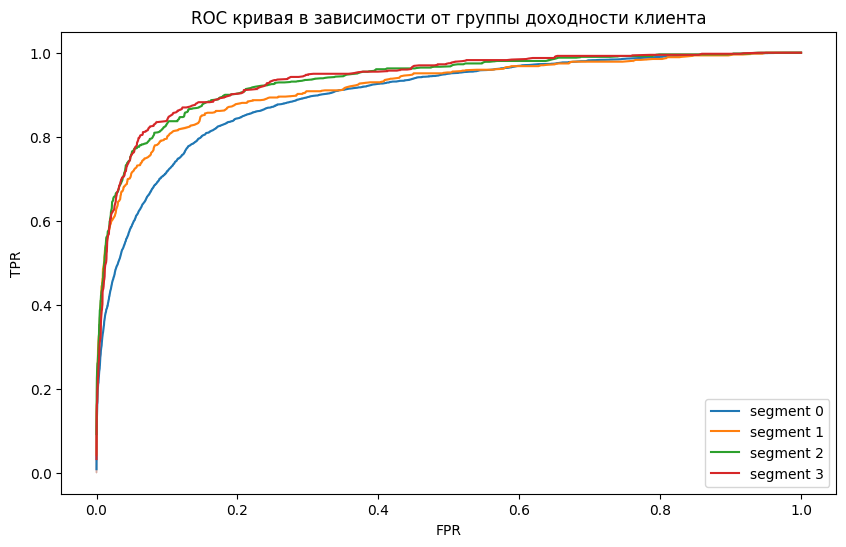

In [137]:
fpr, tpr, _ = roc_curve(X_test_roc[X_test_roc['segment'] == '0']['real_mark'], X_test_roc[X_test_roc['segment'] == '0']['pred_mark'])
fpr1, tpr1, _ = roc_curve(X_test_roc[X_test_roc['segment'] == '1']['real_mark'], X_test_roc[X_test_roc['segment'] == '1']['pred_mark'])
fpr2, tpr2, _ = roc_curve(X_test_roc[X_test_roc['segment'] == '2']['real_mark'], X_test_roc[X_test_roc['segment'] == '2']['pred_mark'])
fpr3, tpr3, _ = roc_curve(X_test_roc[X_test_roc['segment'] == '3']['real_mark'], X_test_roc[X_test_roc['segment'] == '3']['pred_mark'])

plt.figure(figsize=(10, 6))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC кривая в зависимости от группы доходности клиента")
sns.lineplot(x=fpr, y=tpr, label='segment 0')
sns.lineplot(x=fpr1, y=tpr1, label='segment 1')
sns.lineplot(x=fpr2, y=tpr2, label='segment 2')
sns.lineplot(x=fpr3, y=tpr3, label='segment 3')

In [138]:
roc_auc_0 = roc_auc_score(X_test_roc[X_test_roc['segment'] == '0']['real_mark'], X_test_roc[X_test_roc['segment'] == '0']['pred_mark'])
roc_auc_1 = roc_auc_score(X_test_roc[X_test_roc['segment'] == '1']['real_mark'], X_test_roc[X_test_roc['segment'] == '1']['pred_mark'])
roc_auc_2 = roc_auc_score(X_test_roc[X_test_roc['segment'] == '2']['real_mark'], X_test_roc[X_test_roc['segment'] == '2']['pred_mark'])
roc_auc_3 = roc_auc_score(X_test_roc[X_test_roc['segment'] == '3']['real_mark'], X_test_roc[X_test_roc['segment'] == '3']['pred_mark'])
roc_auc_list = []
roc_auc_list.append(roc_auc_0)
roc_auc_list.append(roc_auc_1)
roc_auc_list.append(roc_auc_2)
roc_auc_list.append(roc_auc_3)
roc_auc_list

[0.8975510892881224, 0.9168689317943048, 0.935283788500498, 0.9381026361865306]

### Год получения ОГРН

In [139]:
ogrn_list = X_test_roc['ogrn_year'].unique().tolist()
ogrn_list.remove('None')

['19',
 '5',
 '10',
 '17',
 '14',
 '1',
 '15',
 '20',
 '9',
 '12',
 '2',
 '11',
 '18',
 '0',
 '4',
 '7',
 '16',
 '8',
 '3',
 '13',
 '6']

In [140]:
roc_ogrn_list = []
for i in ogrn_list:
    roc_ogrn_list.append(roc_auc_score(X_test_roc[X_test_roc['ogrn_year'] == i]['real_mark'], X_test_roc[X_test_roc['ogrn_year'] == i]['pred_mark']))

In [141]:
for i in range(len(ogrn_list)):
    ogrn_list[i] = int(ogrn_list[i])    
ogrn_list.sort()

In [142]:
X_test_roc['ogrn_year'] = np.where((X_test_roc['ogrn_year'] == '0') | (X_test_roc['ogrn_year'] == '1') | (X_test_roc['ogrn_year'] == '2'), 0, X_test_roc['ogrn_year'])
X_test_roc['ogrn_year'] = np.where((X_test_roc['ogrn_year'] == '3') | (X_test_roc['ogrn_year'] == '4') | (X_test_roc['ogrn_year'] == '5'), 1, X_test_roc['ogrn_year'])
X_test_roc['ogrn_year'] = np.where((X_test_roc['ogrn_year'] == '6') | (X_test_roc['ogrn_year'] == '7') | (X_test_roc['ogrn_year'] == '8'), 2, X_test_roc['ogrn_year'])
X_test_roc['ogrn_year'] = np.where((X_test_roc['ogrn_year'] == '9') | (X_test_roc['ogrn_year'] == '10') | (X_test_roc['ogrn_year'] == '11'), 3, X_test_roc['ogrn_year'])
X_test_roc['ogrn_year'] = np.where((X_test_roc['ogrn_year'] == '12') | (X_test_roc['ogrn_year'] == '13') | (X_test_roc['ogrn_year'] == '14'), 4, X_test_roc['ogrn_year'])
X_test_roc['ogrn_year'] = np.where((X_test_roc['ogrn_year'] == '15') | (X_test_roc['ogrn_year'] == '16') | (X_test_roc['ogrn_year'] == '17'), 5, X_test_roc['ogrn_year'])
X_test_roc['ogrn_year'] = np.where((X_test_roc['ogrn_year'] == '18') | (X_test_roc['ogrn_year'] == '19') | (X_test_roc['ogrn_year'] == '20'), 6, X_test_roc['ogrn_year'])

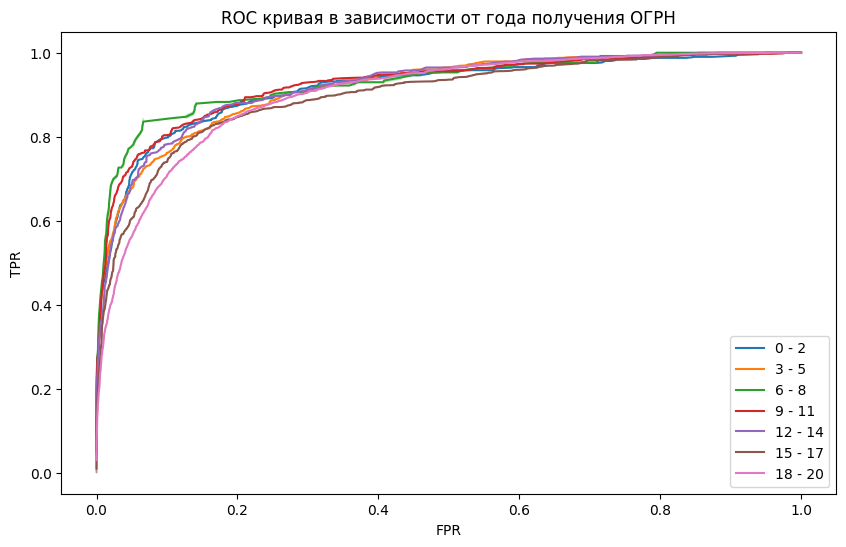

In [143]:
plt.figure(figsize=(10, 6))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC кривая в зависимости от года получения ОГРН")
for i in range(7):
    fpr, tpr, _ = roc_curve(X_test_roc[X_test_roc['ogrn_year'] == i]['real_mark'], X_test_roc[X_test_roc['ogrn_year'] == i]['pred_mark'])
    sns.lineplot(x=fpr, y=tpr, label=str(3 * i) + ' - ' + str(3 * i + 2))

### Месяц получения ОГРН

In [144]:
X_test_roc['ogrn_month'] = np.where((X_test_roc['ogrn_month'] == '0') | (X_test_roc['ogrn_month'] == '1') | (X_test_roc['ogrn_month'] == '2'), 0, X_test_roc['ogrn_month'])
X_test_roc['ogrn_month'] = np.where((X_test_roc['ogrn_month'] == '3') | (X_test_roc['ogrn_month'] == '4') | (X_test_roc['ogrn_month'] == '5'), 1, X_test_roc['ogrn_month'])
X_test_roc['ogrn_month'] = np.where((X_test_roc['ogrn_month'] == '6') | (X_test_roc['ogrn_month'] == '7') | (X_test_roc['ogrn_month'] == '8'), 2, X_test_roc['ogrn_month'])
X_test_roc['ogrn_month'] = np.where((X_test_roc['ogrn_month'] == '9') | (X_test_roc['ogrn_month'] == '10') | (X_test_roc['ogrn_month'] == '11'), 3, X_test_roc['ogrn_month'])

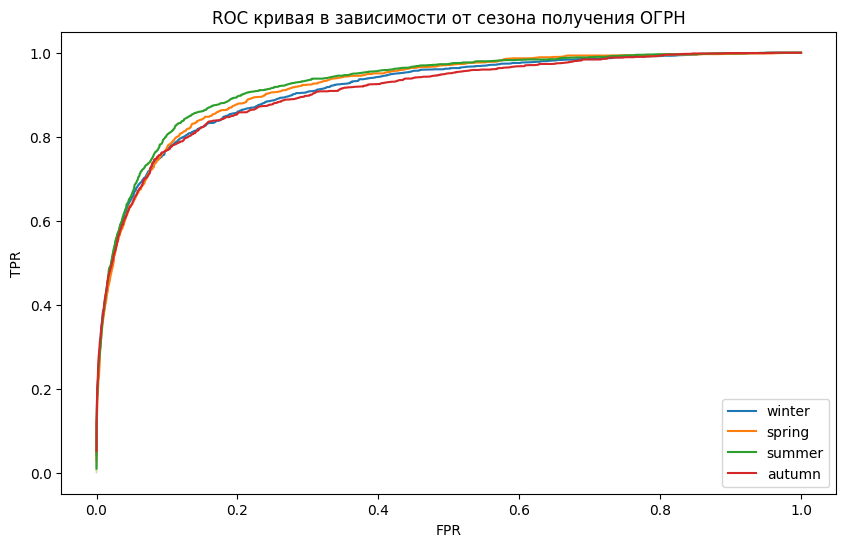

In [146]:
plt.figure(figsize=(10, 6))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC кривая в зависимости от сезона получения ОГРН")
for i in range(4):
    fpr, tpr, _ = roc_curve(X_test_roc[X_test_roc['ogrn_month'] == i]['real_mark'], X_test_roc[X_test_roc['ogrn_month'] == i]['pred_mark'])
    if i == 0:
        sns.lineplot(x=fpr, y=tpr, label='winter')
    if i == 1:
        sns.lineplot(x=fpr, y=tpr, label='spring')
    if i == 2:
        sns.lineplot(x=fpr, y=tpr, label='summer')
    if i == 3:
        sns.lineplot(x=fpr, y=tpr, label='autumn')

# Random Forest

In [23]:
# преобразование категориальных признаков в числовые при помощи Target Encoder
encoders = []
for i in cat_features:
    encoder = TargetEncoder()
    encoder.fit(np.array(X_train[i]).reshape(-1, 1), y_train)
    encoders.append(encoder)
    X_train[i + 'enc'] = encoder.transform(np.array(X_train[i]).reshape(-1, 1))
    X_train = X_train.drop(i, axis=1)

In [24]:
# заполнение пропусков в числовых признаках
tmp = X_train.columns.tolist()
for i in tmp:
    X_train[i] = X_train[i].fillna(X_train[i].median())

In [25]:
# обучаем случайный лес
model1 = RandomForestClassifier(n_estimators=87, min_samples_split=15, min_samples_leaf=10, max_leaf_nodes=50, max_features='sqrt', max_depth=16, bootstrap=True)
model1.fit(X_train, y_train)

RandomForestClassifier(max_depth=16, max_leaf_nodes=50, min_samples_leaf=10,
                       min_samples_split=15, n_estimators=87)

In [26]:
# преобразование тестовой выборки
catLen = len(cat_features)
for i in range(catLen):
    X_test[cat_features[i] + 'enc'] = encoders[i].transform(np.array(X_test[cat_features[i]]).reshape(-1, 1))
    X_test = X_test.drop(cat_features[i], axis=1)

In [27]:
tmp = X_test.columns.tolist()
for i in tmp:
    X_test[i] = X_test[i].fillna(X_test[i].median())

In [28]:
# делаем предикты
predictions2 = model1.predict_proba(X_test)[:, 1]
predictions_mark2 = model1.predict(X_test)

In [29]:
# смотрим значение метрики roc-auc для случайного леса
roc_auc_score(y_test, predictions2)

0.8736775815539612

In [30]:
# смотрим значение метрики preсision
precision_score(y_test, predictions_mark2)

0.691771269177127

In [31]:
# смотрим значение метрики recall
recall_score(y_test, predictions_mark2)

0.09636681562074995

# Обучаем метаалгоритм (Логистическая регрессия)

In [32]:
# составим датафрейм из результатов работы алгоритмов
pred_df = pd.DataFrame({'boosting' : predictions, 'random_forest' : predictions2, 'real_mark' : y_test})
pred_df

,boosting,random_forest,real_mark
76637,0.038415,0.133624,0
64372,0.010584,0.015656,0
252387,0.118257,0.154006,1
251573,0.040906,0.039157,0
318742,0.173726,0.066155,1
...,...,...,...
81952,0.004278,0.014513,0
146033,0.000960,0.012575,0
155535,0.001080,0.013929,0
295431,0.008285,0.014617,0


In [33]:
# определим датафреймы X и y
X_log = pred_df[['boosting', 'random_forest']]
y_log = pred_df['real_mark']

In [34]:
# смотрим значение метрики roc-auc для логистической регрессии
model_log = LogisticRegression(C=0.2, penalty='l2', solver='lbfgs', max_iter=1000)
cross_val_score(estimator=model_log, X=X_log, y=y_log, cv=5)

array([0.94798611, 0.94555556, 0.94625   , 0.94819444, 0.94486111])

In [35]:
# обучаем логистическую регрессию
model_log.fit(X_log, y_log)

LogisticRegression(C=0.2, max_iter=1000)

# Делаем предсказания

In [28]:
# читаем датасет
test_df = pd.read_parquet('test.parquet', engine='pyarrow')
test_df.head(5)

,id,rko_start_months,max_end_fact_fin_deals,max_end_plan_non_fin_deals,max_start_fin_deals,max_start_non_fin_deals,min_end_fact_fin_deals,min_end_plan_non_fin_deals,min_start_fin_deals,min_start_non_fin_deals,...,cnt_days_deb_g_oper_3m,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m
0,360000,61.061808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.531871,51005.755087,4.275226,4.257042,33195.968822,1.229488,0.359263,301442.064297,7.049883,7.069157
1,360001,16.803743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.531871,11.888083,0.275226,0.257042,33195.968822,1.229488,0.359263,125727.663401,1.049883,1.069157
2,360002,15.448904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.531871,11.888083,0.275226,0.257042,33195.968822,1.229488,0.359263,125727.663401,1.049883,1.069157
3,360003,11.287614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.531871,11.888083,0.275226,0.257042,33195.968822,1.229488,0.359263,125727.663401,1.049883,1.069157
4,360004,7.997291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.531871,11.888083,0.275226,0.257042,135758.248681,2.229488,1.359263,126742.064297,2.049883,2.069157


In [29]:
# заменяем некорректные данные на nan
for i in negative_features:
    test_df.loc[test_df[i] < 0, i] = np.nan

In [30]:
# заменяем некорректные данные на nan
tmp = test_df.columns.tolist()
oper_features = [i for i in tmp if 'oper' in i]
for i in oper_features:
    test_df.loc[test_df[i] < 0, i] = np.nan

In [31]:
# вводим два новых признака: сумма всех операций за последний месяц и за последние 3 месяца
cnt_1m = ['cnt_a_oper_1m', 'cnt_b_oper_1m', 'cnt_c_oper_1m', 'cnt_deb_d_oper_1m',
       'cnt_cred_d_oper_1m', 'cnt_deb_e_oper_1m', 'cnt_cred_e_oper_1m',
       'cnt_deb_f_oper_1m', 'cnt_cred_f_oper_1m', 'cnt_deb_g_oper_1m',
       'cnt_cred_g_oper_1m', 'cnt_deb_h_oper_1m', 'cnt_cred_h_oper_1m',]
cnt_3m = ['cnt_a_oper_3m', 'cnt_b_oper_3m', 'cnt_c_oper_3m',
       'cnt_deb_d_oper_3m', 'cnt_cred_d_oper_3m', 'cnt_deb_e_oper_3m',
       'cnt_cred_e_oper_3m', 'cnt_deb_f_oper_3m', 'cnt_cred_f_oper_3m',
       'cnt_deb_g_oper_3m', 'cnt_cred_g_oper_3m', 'cnt_deb_h_oper_3m',
       'cnt_cred_h_oper_3m']
test_df['cnt_oper_1m'] = test_df[cnt_1m].sum(axis = 1)
test_df['cnt_oper_3m'] = test_df[cnt_3m].sum(axis = 1)
test_df = test_df.drop(columns=cnt_1m, axis=1)
test_df = test_df.drop(columns=cnt_3m, axis=1)

In [32]:
# посчитаем пропущенные значения
missing_values = pd.DataFrame({'feature' : test_df.columns.tolist(), 'count' : test_df.isna().sum().tolist()})
missing_values

,feature,count
0,id,0
1,rko_start_months,23
2,max_end_fact_fin_deals,86909
3,max_end_plan_non_fin_deals,93549
4,max_start_fin_deals,86909
...,...,...
71,cnt_days_deb_h_oper_3m,1208
72,sum_cred_h_oper_3m,0
73,cnt_days_cred_h_oper_3m,1208
74,cnt_oper_1m,0


In [33]:
# удалим колонки в которых больше половины пропусков
drop_features = missing_values[missing_values['count'] > (test_df.shape[0] / 2)]['feature'].tolist()
test_df = test_df.drop(columns=drop_features, axis=1)

In [34]:
# определим функцию дял очистки категориальных признаков
def func(s):
    if s == None:
        return 'None'
    status = s.isdigit()
    if status == True:
        return s
    else:
        return 'None'

In [35]:
# очищаем категориальные признаки
test_df['city'] = test_df['city'].apply(func)
test_df['city_type'] = test_df['city_type'].apply(func)
test_df['ogrn_month'] = test_df['ogrn_month'].apply(func)
test_df['ogrn_year'] = test_df['ogrn_year'].apply(func)
test_df['okved'] = test_df['okved'].apply(func)
test_df['segment'] = test_df['segment'].apply(func)
test_df['branch_code'] = test_df['branch_code'].apply(func)

In [36]:
# подготавлеваем данные для бустинга
X_test = test_df[np.concatenate((cat_features, numeric_features), axis=0)]
X_test

,city,city_type,ogrn_month,ogrn_year,okved,segment,branch_code,rko_start_months,balance_amt_avg,balance_amt_max,...,sum_deb_g_oper_3m,cnt_days_deb_g_oper_3m,sum_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_days_cred_h_oper_3m,cnt_oper_1m,cnt_oper_3m
0,None,None,9,12,64,2,58,61.061808,2.735668e+04,7.416109e+04,...,629.592452,0.531871,51005.755087,4.257042,33195.968822,0.359263,3.014421e+05,7.069157,33.632651,65.31198
1,3111,3597,2,0,17,2,151,16.803743,1.654578e+06,1.729187e+06,...,629.592452,0.531871,11.888083,0.257042,33195.968822,0.359263,1.257277e+05,1.069157,12.632651,13.31198
2,None,None,11,19,41,0,341,15.448904,5.315305e+04,9.921213e+04,...,629.592452,0.531871,11.888083,0.257042,33195.968822,0.359263,1.257277e+05,1.069157,13.632651,16.31198
3,None,None,4,17,17,2,358,11.287614,7.648909e+04,1.224288e+05,...,629.592452,0.531871,11.888083,0.257042,33195.968822,0.359263,1.257277e+05,1.069157,0.000000,15.31198
4,3071,3597,10,15,41,3,13,7.997291,9.232664e+04,1.755382e+05,...,629.592452,0.531871,11.888083,0.257042,135758.248681,1.359263,1.267421e+05,2.069157,29.632651,68.31198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,None,None,10,17,41,0,317,19.836001,6.167157e+04,1.074278e+06,...,629.053885,1.531871,11.888083,0.257042,33195.968822,0.359263,1.257277e+05,1.069157,18.632651,20.31198
99996,5430,3597,1,1,41,0,176,49.319872,3.669695e+04,1.049396e+05,...,3353.703885,65.531871,11.888083,0.257042,33195.968822,0.359263,1.257277e+05,1.069157,294.632651,701.31198
99997,None,None,7,8,46,3,13,43.965033,5.108252e+05,7.500329e+05,...,629.592452,0.531871,11.888083,0.257042,76611.048681,5.359263,1.257277e+05,1.069157,241.632651,751.31198
99998,None,None,5,12,11,0,150,38.255356,4.560422e+04,9.160741e+04,...,3433.293885,3.531871,15005.755087,1.257042,33195.968822,0.359263,1.257277e+05,1.069157,21.632651,38.31198


In [37]:
# получаем предикты от бустинга
test_score_boost = model.predict_proba(X_test)[:, 1]

In [38]:
# преобразовываем категорильные признаки для работы random forest
catLen = len(cat_features)
for i in range(catLen):
    X_test[cat_features[i] + 'enc'] = encoders[i].transform(np.array(X_test[cat_features[i]]).reshape(-1, 1))
    X_test = X_test.drop(cat_features[i], axis=1)

C:\Users\79237\AppData\Local\Temp\ipykernel_12232\1225956106.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[cat_features[i] + 'enc'] = encoders[i].transform(np.array(X_test[cat_features[i]]).reshape(-1, 1))


In [39]:
# заполняем пропуски в числовых признаках
tmp = X_test.columns.tolist()
for i in tmp:
    X_test[i] = X_test[i].fillna(X_test[i].median())

In [40]:
# получаем предикты от random forest
test_score_forest = model1.predict_proba(X_test)[:, 1]

In [41]:
# собираем предсказания в датафрейм
test_score_df = pd.DataFrame({'boosting' : test_score_boost, 'random_forest' : test_score_forest})
test_score_df

,boosting,random_forest
0,0.042604,0.064278
1,0.024823,0.132709
2,0.158916,0.091677
3,0.047414,0.077195
4,0.041824,0.048279
...,...,...
99995,0.021732,0.112769
99996,0.043920,0.031107
99997,0.007137,0.015693
99998,0.028008,0.047199


In [42]:
# выполняем финальные предсказания
final_pred = model_log.predict_proba(test_score_df)[:, 1]

In [43]:
sample_submission_df = pd.read_csv("sample_submission.csv")
sample_submission_df["score"] = final_pred

In [58]:
# загружаем решение
sample_submission_df.to_csv("my_submission.csv", index=False)